In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import rcParams
from sklearn.ensemble import IsolationForest
import utils

rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42

In [29]:
cam_data = pd.read_pickle('../traffic_data/raw_station_segment_data.pkl')
bus_data = pd.read_pickle('../traffic_data/raw_bus_data.pkl')
bus_data_coords = pd.read_pickle('../traffic_data/raw_data_with_corrigated_coords.pkl')
cam_data_month = pd.read_parquet('../traffic_data/raw_station_segment_data_2021-12-01_2022-01-01.parquet')
cam_data_month['timestamp'] = pd.to_datetime(cam_data_month['timestamp'], unit='s')

In [30]:
bus_data_coords = utils.preprocess_bus_data(bus_data_coords)
bus_data = utils.preprocess_bus_data(bus_data)
bus_data = utils.day_filter(bus_data,10)

#Visualization

###Cam Data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


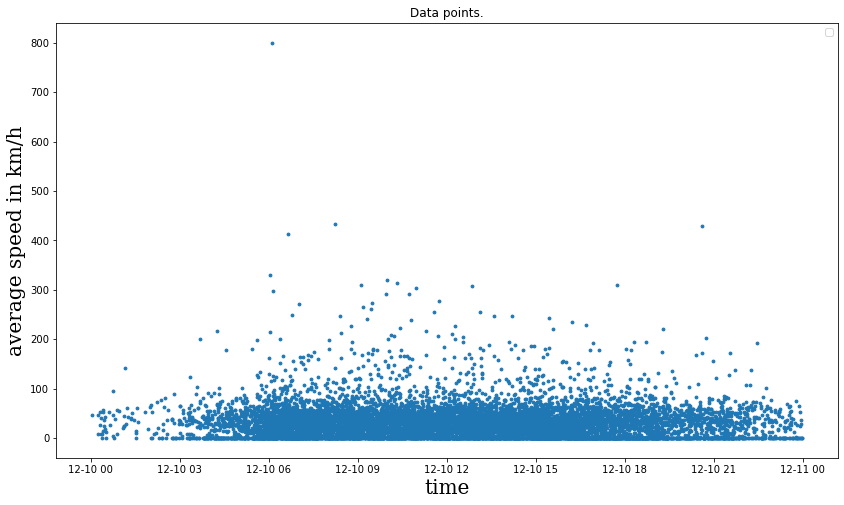

In [48]:
font = {'family':'serif','size':20}
plt.scatter(x=cam_data['timestamp'],y=cam_data['avg_speed'],s = 8)
plt.title("Data points.")
plt.xlabel("time",fontdict=font)
plt.ylabel("average speed in km/h",fontdict=font)
plt.legend()
plt.show()

<AxesSubplot:xlabel='timestamp'>

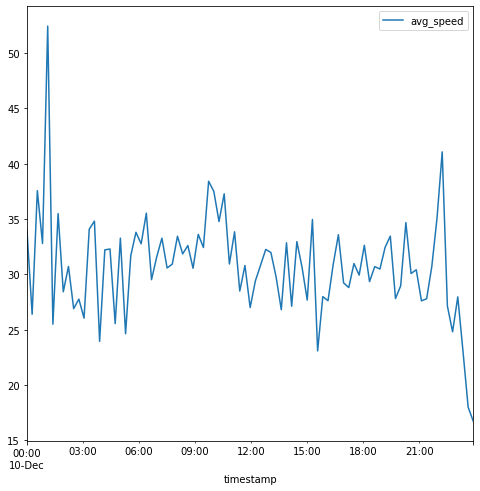

In [32]:
utils.resample(cam_data,'avg_speed',1000).plot.line(x='timestamp',y='avg_speed',figsize=(8,8))

<AxesSubplot:xlabel='timestamp'>

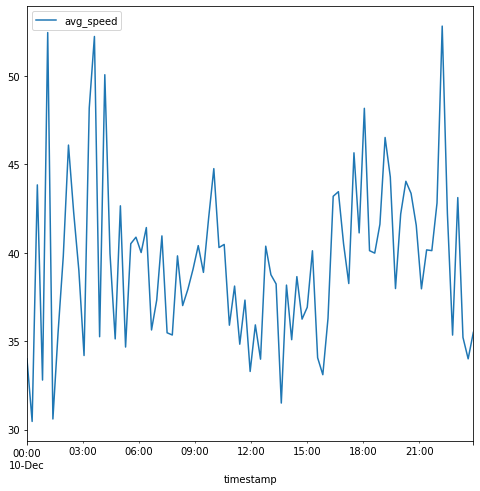

In [33]:
utils.resample(cam_data[cam_data['avg_speed'] != 0],'avg_speed',1000).plot.line(x='timestamp',y='avg_speed',figsize=(8,8))

<AxesSubplot:xlabel='timestamp'>

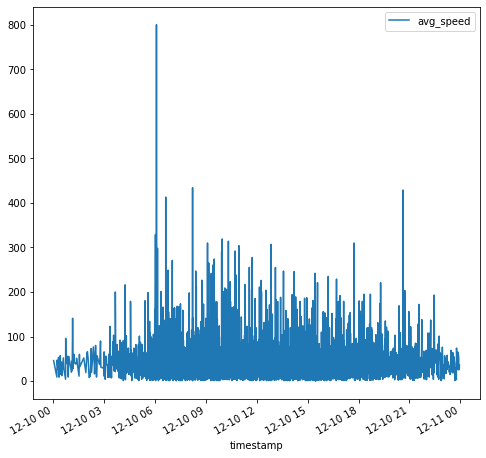

In [34]:
plot_data = cam_data[cam_data['avg_speed'] != 0]
plot_data.plot.line(x='timestamp',y='avg_speed',figsize=(8,8))

### Bus data

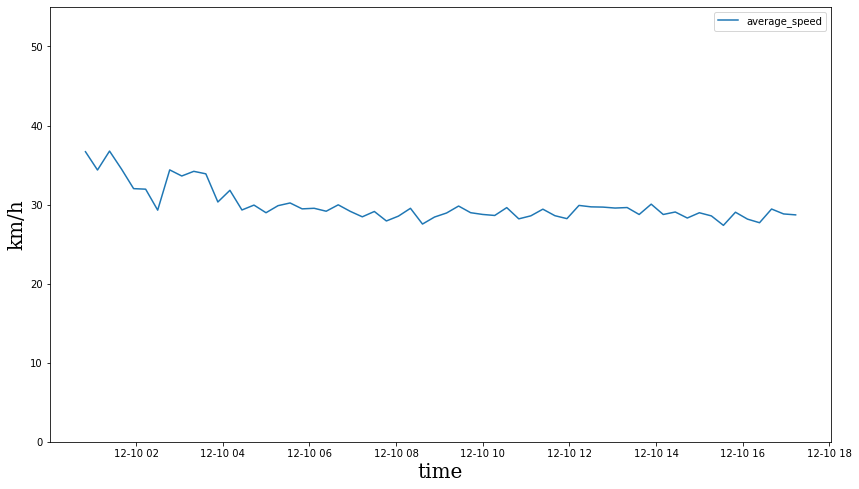

In [51]:
plot_bus_frame = utils.resample(bus_data[bus_data['velocity']!=0],'velocity',1000)
font = {'family': 'serif', 'size': 20}
plt.plot(plot_bus_frame['timestamp'], plot_bus_frame['velocity'], label='average_speed')
plt.xlabel("time", fontdict=font)
plt.ylabel("km/h", fontdict=font)
plt.ylim(0,55)
plt.legend()
plt.show()

## Cam Data

In [36]:
cam_data_cleaned = utils.thresholding(daylim = 70,nightlim = 90,frame = cam_data,keepzeros=True)
len(cam_data_cleaned)

8753

In [37]:
outlier_fraction = (len(cam_data)-len(cam_data_cleaned))/(len(cam_data))

In [38]:
outlier_fraction

0.0726771903803369

In [39]:
cam_data_joined = utils.create_joined_cam_data(cam_data_month,10)
cam_data_joined = cam_data_joined[cam_data_joined[['avg_speed', 'total_flow']].notnull().all(1)]
cam_data_joined = cam_data_joined.reset_index()

C:\Users\domon\PycharmProjects\outlier_detection\traffic_outlier_detection\utils.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[column_name] = frame['value']
C:\Users\domon\PycharmProjects\outlier_detection\traffic_outlier_detection\utils.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[column_name] = frame['value']


In [40]:
train_data = cam_data_joined.drop(['timestamp'], axis=1)

In [41]:
estimator = IsolationForest(n_estimators=100,contamination=outlier_fraction*1.3,max_samples='auto')
prediction = estimator.fit_predict(train_data)

C:\Users\domon\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [42]:
print(prediction[:20])
print("Number of outliers detected: {}".format(prediction[prediction < 0].sum()))
print("Number of normal samples detected: {}".format(prediction[prediction > 0].sum()))
print(len(prediction))

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1  1  1 -1 -1]
Number of outliers detected: -171
Number of normal samples detected: 1636
1807


In [43]:
normal_data = cam_data_joined[cam_data_joined.index.isin(np.where(prediction > 0)[0])]
outliers = cam_data_joined[cam_data_joined.index.isin(np.where(prediction < 0)[0])]
len(outliers)

171

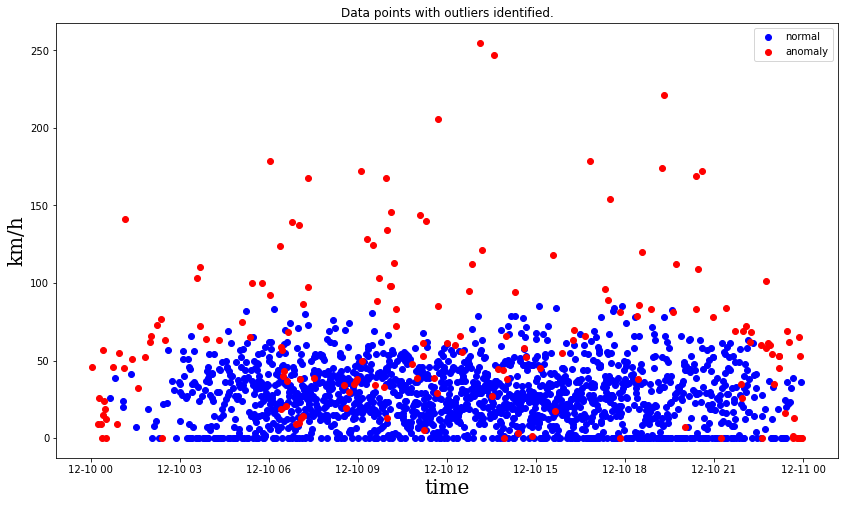

In [44]:
font = {'family':'serif','size':20}
plt.scatter(x=normal_data['timestamp'],y=normal_data['avg_speed'],color='b',label='normal')
plt.scatter(x=outliers['timestamp'],y=outliers['avg_speed'],color='r',label='anomaly')
plt.title("Data points with outliers identified.")
plt.xlabel("time",fontdict=font)
plt.ylabel("km/h",fontdict=font)
plt.legend()
plt.show()

In [45]:
plot_bus = utils.resample(bus_data,'velocity',1000)
plot_camera = utils.resample(normal_data,'avg_speed',1000)
plot_camera_before = utils.resample(cam_data,'avg_speed',1000)
plot_bus = plot_bus[plot_bus['velocity'] != 0]
plot_camera = plot_camera[plot_camera['avg_speed'] != 0]
plot_camera_before = plot_camera_before[plot_camera_before['avg_speed'] != 0]

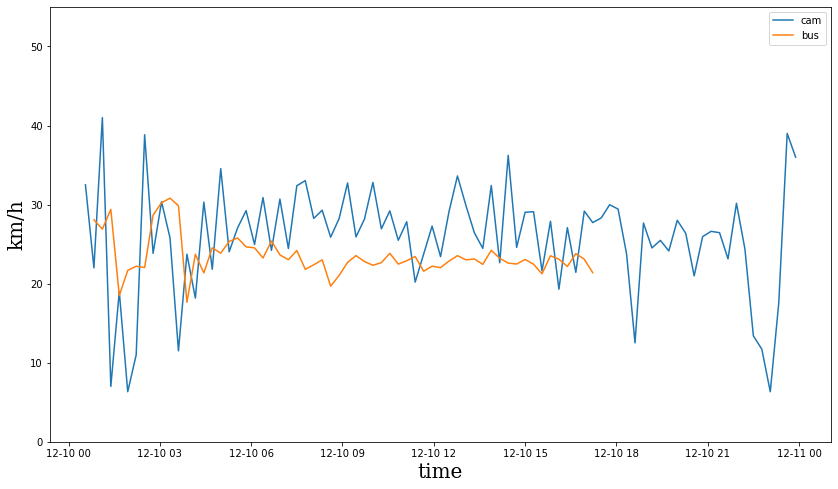

In [46]:
utils.two_line_plot(plot_bus,plot_camera)

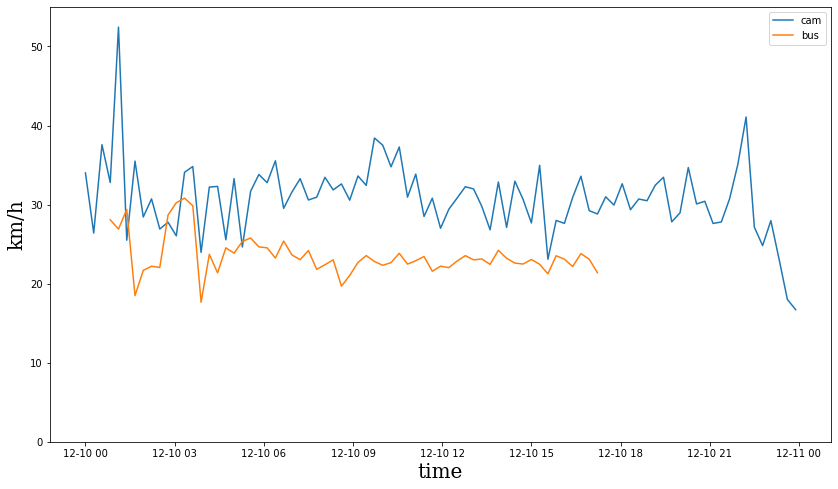

In [47]:
utils.two_line_plot(plot_bus,plot_camera_before)